# Problem Statement
Factors effecting the booking of the cycles. To find the relation between the Season,Weather or Working day with rental.

# Understanding the data

- ****timestamp**** - timestamp field for grouping the data
- ****cnt**** - the count of a new bike shares
- ****t1**** - real temperature in C
- ****t2**** - temperature in C "feels like"
- ****hum**** - humidity in percentage
- ****windspeed**** - wind speed in km/h
- ****weathercode**** - category of the weather
    - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
    - 2 = scattered clouds / few clouds 
    - 3 = Broken clouds 
    - 4 = Cloudy 
    - 7 = Rain/ light Rain shower/ Light rain 
    - 10 = rain with thunderstorm 
    - 26 = snowfall
    
    
- ***isholiday**** - boolean field - 1 holiday / 0 non holiday
- ****isweekend**** - boolean field - 1 if the day is weekend
- ****season**** - category(0-spring ; 1-summer; 2-fall; 3-winter)


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import boxcox,yeojohnson

In [3]:
data = pd.read_csv('../input/london-bike-sharing-dataset/london_merged.csv')

In [4]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [5]:
data.shape

(17414, 10)

****We have around 17K booking records.****

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


****Most of the data is numerical instead of timestamp****

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
cnt,17414.0,1143.101642,1085.108068,0.0,257.0,844.0,1671.75,7860.0
t1,17414.0,12.468091,5.571818,-1.5,8.0,12.5,16.00,34.0
t2,17414.0,11.520836,6.615145,-6.0,6.0,12.5,16.00,34.0
hum,17414.0,72.324954,14.313186,20.5,63.0,74.5,83.00,100.0
wind_speed,17414.0,15.913063,7.894570,0.0,10.0,15.0,20.50,56.5
weather_code,17414.0,2.722752,2.341163,1.0,1.0,2.0,3.00,26.0
is_holiday,17414.0,0.022051,0.146854,0.0,0.0,0.0,0.00,1.0
is_weekend,17414.0,0.285403,0.451619,0.0,0.0,0.0,1.00,1.0
season,17414.0,1.492075,1.118911,0.0,0.0,1.0,2.00,3.0


### From the above data we can infer - 
- Season, Holiday, Weekend, Weather despite being numerical is categorical in nature
- Avg real temp is around 12.5° celcius
- Avg feels like temperature is around 11.5° celcius
- Riders count average is around 1143 but max value is 7860 so there is a hint of outliers

# Adding Month and Year column for better understanding of data

In [8]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [9]:
data['year'] = data['timestamp'].dt.year

In [10]:
data['month'] = data['timestamp'].dt.month

In [11]:
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,year,month
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,2015,1
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,2015,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2015,1
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,2015,1
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,2015,1


# Non Graphical Analysis

In [12]:
data.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
year            0
month           0
dtype: int64

****There is no null data.****

In [13]:
data['season'].value_counts(ascending=False)

0.0    4394
1.0    4387
3.0    4330
2.0    4303
Name: season, dtype: int64

****Almost all the four seasons share the equal amount of records****

In [14]:
data['is_holiday'].value_counts()

0.0    17030
1.0      384
Name: is_holiday, dtype: int64

****More booking data is from Non Holiday than a holiday****

In [15]:
data['weather_code'].value_counts(ascending=False)

1.0     6150
2.0     4034
3.0     3551
7.0     2141
4.0     1464
26.0      60
10.0      14
Name: weather_code, dtype: int64

### Dropping weather code 26 and 10 as they have very less number of records.

In [16]:
data = data[(data['weather_code']!=10) & (data['weather_code']!=26)]

In [17]:
data['is_weekend'].value_counts()

0.0    12399
1.0     4941
Name: is_weekend, dtype: int64

****More booking data is from Non Weekend than a weekends****

In [18]:
data.groupby(['weather_code'])['cnt'].mean()

weather_code
1.0    1162.088943
2.0    1496.177491
3.0    1195.124472
4.0     635.230874
7.0     712.966371
Name: cnt, dtype: float64

****Most booking data is from weather type 1 followed by type 2 and type 3.****

# Univariate Analysis

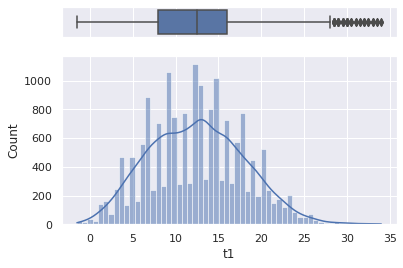

In [19]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='t1', ax=ax_box)
sns.histplot(data=data, x="t1", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

# Treating outliers

In [20]:
Q3 = data['t1'].quantile(0.75)
Q1 = data['t1'].quantile(0.25)
IQR = Q3-Q1
upper = Q3+(1.5*IQR)
lower = Q1-(1.5*IQR)
(upper,lower)

(28.0, -4.0)

In [21]:
data = data[(data['t1']>lower) & (data['t1']<upper)]

## Plotting graph to check data after outlier treatment

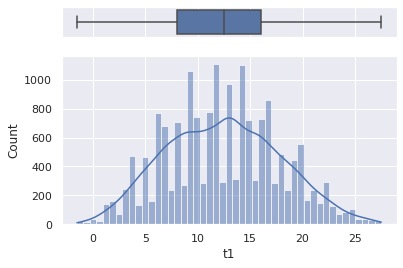

In [22]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='t1', ax=ax_box)
sns.histplot(data=data, x="t1", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

### From the above graph we can infer - 
- Avg real temperature is around 13° celcius 
- 25% of temperature is around 9.5° celcius
- 75% of temperature is around 15.5° celcius

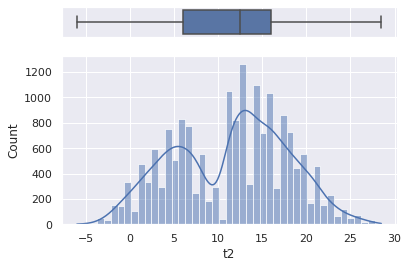

In [23]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='t2', ax=ax_box)
sns.histplot(data=data, x="t2", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

### From the above graph we can infer - 
- Avg feels like temperature is around 13° celcius 
- 25% of feels like temperature is around 5° celcius
- 75% of feels like temperature is around 16° celcius

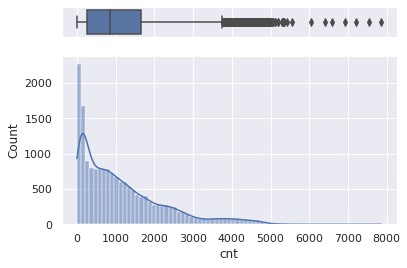

In [24]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='cnt', ax=ax_box)
sns.histplot(data=data, x="cnt", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

## There are lot of outliers lets transform the data.

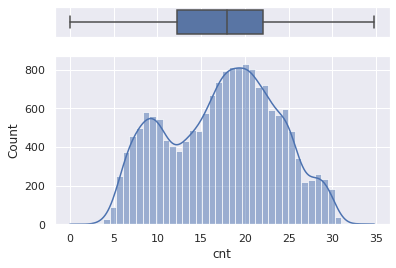

In [25]:
data['cnt'] = (yeojohnson(data['cnt'])[0])
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='cnt', ax=ax_box)
sns.histplot(data=data, x="cnt", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

### From the above graph we can infer - 
- Avg cnt is around 2000
- 25% of temperature is around 1500
- 75% of temperature is around 2200

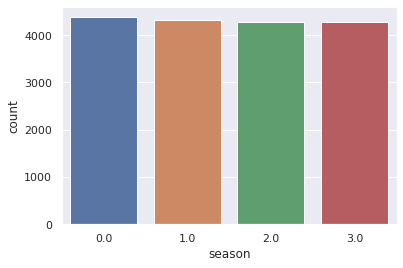

In [26]:
sns.countplot(data=data,x='season')
plt.show()

****As already infered, almost all the four seasons share the equal amount of data****

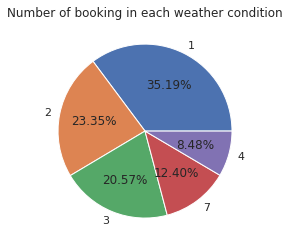

In [27]:
type_value_count = data['weather_code'].value_counts(normalize=True)*100
plt.pie(type_value_count,labels=[1,2,3,7,4],autopct='%1.2f%%')
plt.title('Number of booking in each weather condition')
plt.show()

****Most booking data is from weather type 1 followed by type 2 and type 3.****

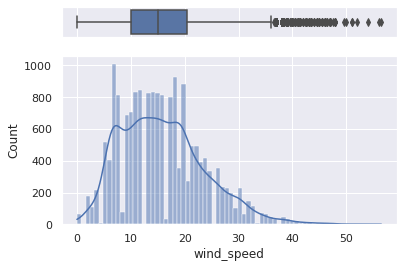

In [28]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='wind_speed', ax=ax_box)
sns.histplot(data=data, x="wind_speed", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

# Treating outliers

In [29]:
Q3 = data['wind_speed'].quantile(0.75)
Q1 = data['wind_speed'].quantile(0.25)
IQR = Q3-Q1
upper = Q3+(1.5*IQR)
lower = Q1-(1.5*IQR)
(upper,lower)

(36.25, -5.75)

In [30]:
data = data[(data['wind_speed']>lower) & (data['wind_speed']<upper)]

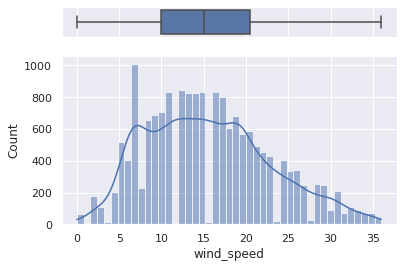

In [31]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='wind_speed', ax=ax_box)
sns.histplot(data=data, x="wind_speed", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

## From the above graphs, we can say - 
 - Windspeed is normally in the range of 0 to 35
 - Avg wind speed is 15
 - 25% of wind speed is under 12
 - 75% of wind speed is under 19

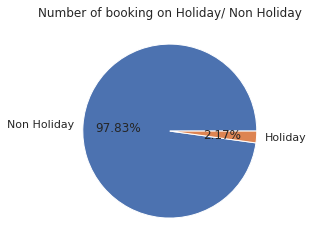

In [32]:
type_value_count = data['is_holiday'].value_counts(normalize=True)*100
plt.pie(type_value_count,labels=['Non Holiday','Holiday'],autopct='%1.2f%%')
plt.title('Number of booking on Holiday/ Non Holiday')
plt.show()

****Most of the booking data is from Non Holiday than a Holiday.****

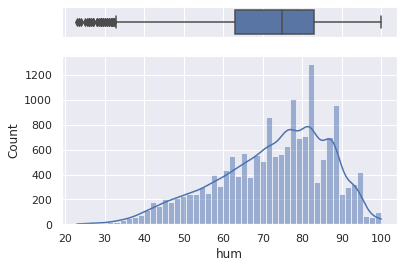

In [33]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='hum', ax=ax_box)
sns.histplot(data=data, x="hum", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

In [34]:
Q3 = data['hum'].quantile(0.75)
Q1 = data['hum'].quantile(0.25)
IQR = Q3-Q1
upper = Q3+(1.5*IQR)
lower = Q1-(1.5*IQR)
(upper,lower)

(113.0, 33.0)

In [35]:
data = data[(data['hum']>lower) & (data['hum']<upper)]

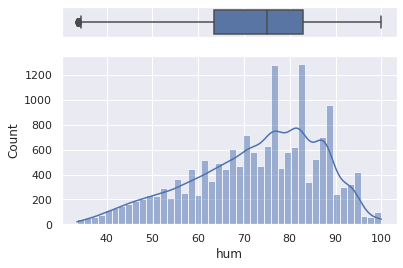

In [36]:
sns.set(style="darkgrid")
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(data=data,x='hum', ax=ax_box)
sns.histplot(data=data, x="hum", ax=ax_hist,kde=True)
ax_box.set(xlabel='')
plt.show()

# Bi-Variate Analysis

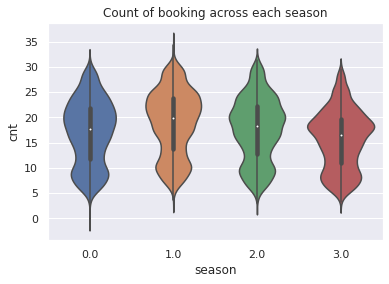

In [37]:
sns.violinplot(y='cnt',x='season',data=data)
plt.title('Count of booking across each season')
plt.show()

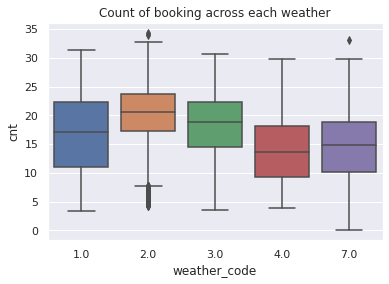

In [38]:
sns.boxplot(y='cnt',x='weather_code',data=data)
plt.title('Count of booking across each weather')
plt.show()

### From the above graph we can infer - 
- Most count of booking came from season 2. 
- Season 1 sees less number of count of booking.

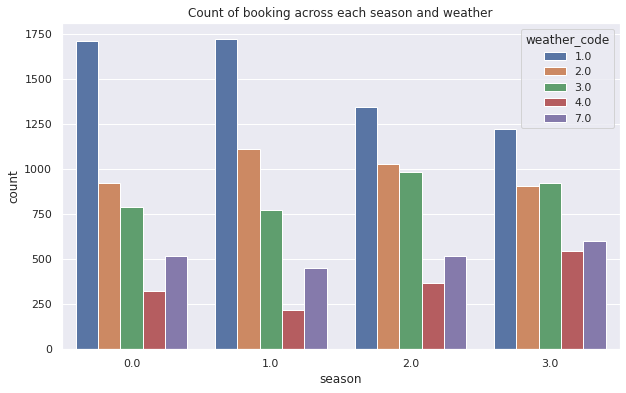

In [39]:
plt.figure(figsize=(10,6))
sns.countplot(x='season',hue='weather_code',data=data)
plt.title('Count of booking across each season and weather')
plt.show()

### From the above graph we can infer - 
- Almost all the weather condition is same across the seasons
- Weather 1,2 and 3 sees less booking compared to Weather 4 and 7 across all season

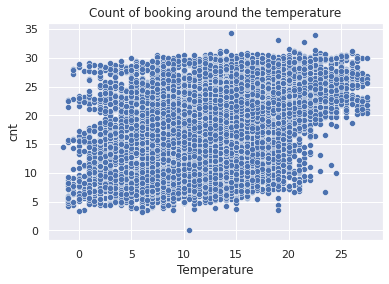

In [40]:
sns.scatterplot(x='t1',y='cnt',data=data)
plt.title('Count of booking around the temperature')
plt.xlabel('Temperature')
plt.show()

****There is a uniform distribution of count of booking across all the temperature.****

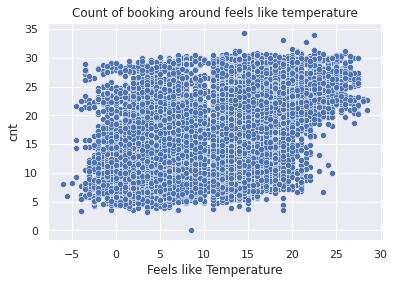

In [41]:
sns.scatterplot(x='t2',y='cnt',data=data)
plt.title('Count of booking around feels like temperature')
plt.xlabel('Feels like Temperature')
plt.show()

****There is a uniform distribution of count of booking across all the feels like temperature.****

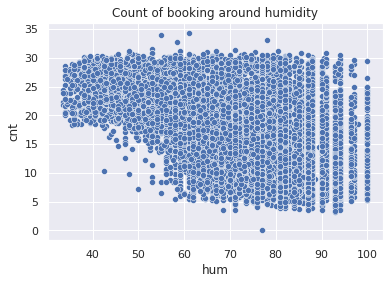

In [42]:
sns.scatterplot(x='hum',y='cnt',data=data)
plt.title('Count of booking around humidity')
plt.show()

****There is higher booking when the humidity id less.****

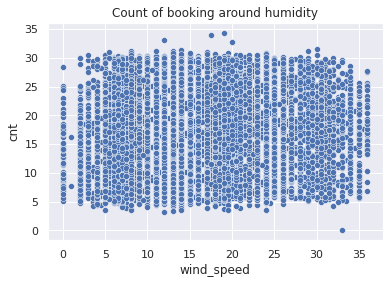

In [43]:
sns.scatterplot(x='wind_speed',y='cnt',data=data)
plt.title('Count of booking around humidity')
plt.show()

****There is a uniform distribution of count of booking for all wind speeds.****

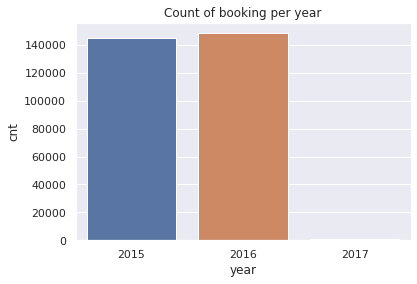

In [44]:
year_data = data.groupby(['year'])['cnt'].sum()
year_data = year_data.reset_index()
sns.barplot(x='year',y='cnt',data=year_data)
plt.title('Count of booking per year')
plt.show()

****Booking from 2017 is nearly zero so far.****

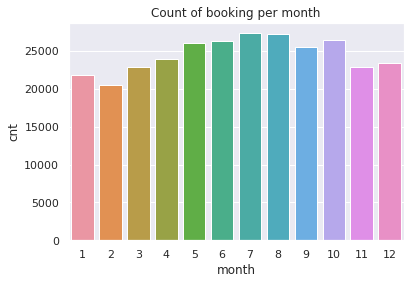

In [45]:
month_data = data.groupby(['month'])['cnt'].sum()
month_data = month_data.reset_index()
sns.barplot(x='month',y='cnt',data=month_data)
plt.title('Count of booking per month')
plt.show()

****Almost all the months have same number of bookings.****

In [46]:
mon_year_data = data.groupby(['year','month'])['cnt'].sum()
mon_year_data = pd.DataFrame(mon_year_data)
mon_year_data.reset_index(inplace = True)
myy = mon_year_data.pivot('month','year','cnt').fillna(0)

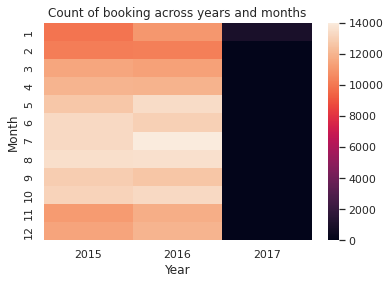

In [47]:
sns.heatmap(myy)
plt.title('Count of booking across years and months')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

****As infered earlier the data booking is almost same across all the months.****

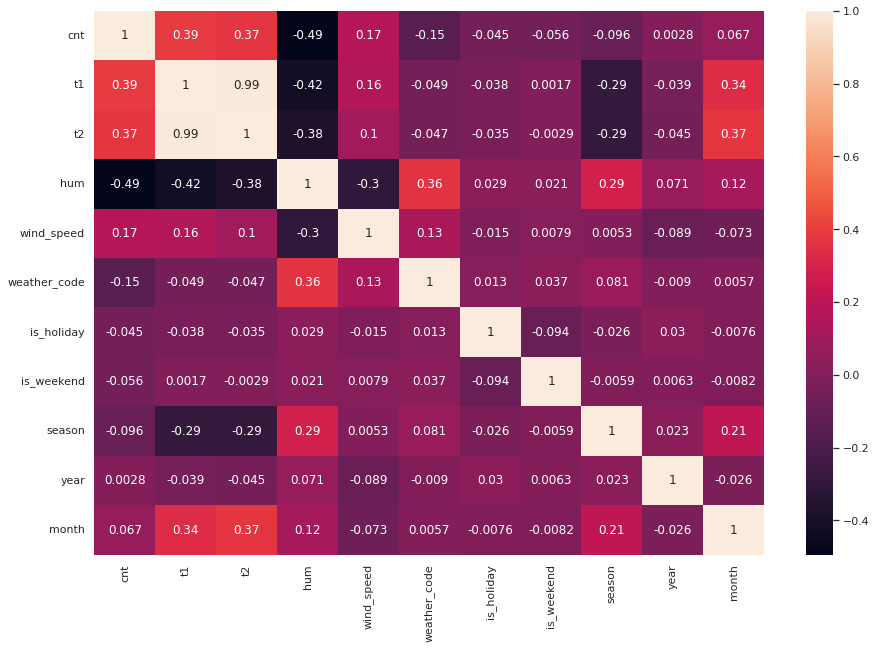

In [48]:
plt.figure(figsize=(15,10))
sns.heatmap(data.corr(),annot=True)
plt.show()

### From the above graph we can infer -
- There is a high correlation of actual temperature with feels like teperature.
- Similarly temp and feels like temp as well as month and seasons are having good correlation.

# Hypothesis Testing

Decribing a fuction to yield result on the basis of given significance value - 0.05¶

In [49]:
def htResult(p_value):
    significance_level = 0.05
    if p_value <= significance_level: 
        print('Reject NULL HYPOTHESIS') 
    else: 
        print('Fail to Reject NULL HYPOTHESIS') 

## Question - 
Does holiday has an effect on the number of electric cycles rented?

****Null hypothesis, H0****        : There is no effect of holiday on cycles rented.

****Alternate hypothesis, Ha****   : There is some effect of holiday on cycles rented.

In [50]:
working = data[data['is_holiday']==0]
not_working = data[data['is_holiday']==1]

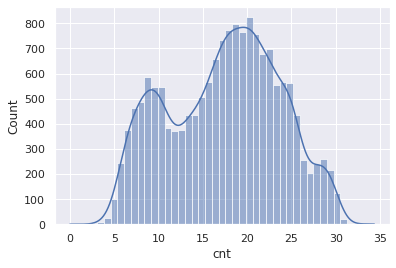

In [51]:
sns.histplot(x='cnt', data=working, kde = True)
plt.show()

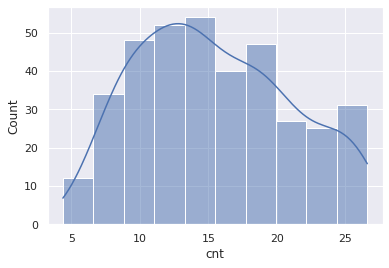

In [52]:
sns.histplot(x='cnt', data=not_working, kde = True)
plt.show()

### From the above graphs we can say that distribution of data is almost normal.
## Normality check of the data (Q-Q plot)

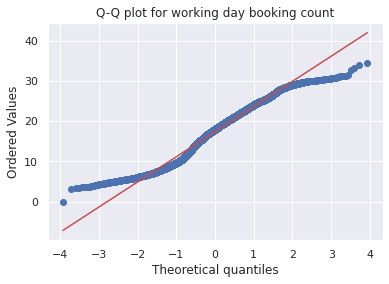

In [53]:
stats.probplot(working['cnt'], plot= plt, dist="norm")
plt.title('Q-Q plot for working day booking count')
plt.show()

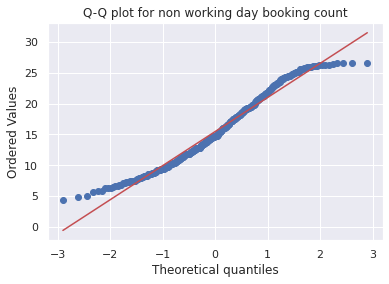

In [54]:
stats.probplot(not_working['cnt'], plot= plt, dist="norm")
plt.title('Q-Q plot for non working day booking count')
plt.show()

****From both the Q-Q Plot we can say that the values are near normal****

## Performing t-test
Basic assupmtions met

In [55]:
t_test = stats.ttest_ind(working['cnt'], not_working['cnt'])
p_value = t_test.pvalue
print("P-value :",p_value)

P-value : 4.823003037225899e-09


In [56]:
htResult(p_value)

Reject NULL HYPOTHESIS


# Answer - 
****We reject Null Hypothesis, which means holiday has effect on bikes rented.****

## Question -
To check if Weather is dependent on the season.

****Null hypothesis, H0****        : Weather is not dependant on the season.

****Alternate hypothesis, Ha****   : Weather is dependant on the season.

In [57]:
cont = pd.crosstab(data['weather_code'],data['season'])

## Performing Chi Square Test

In [58]:
c, p, dof, expected = stats.chi2_contingency(cont)

In [59]:
print('P-value :',p)

P-value : 5.524219997335384e-72


In [60]:
htResult(p)

Reject NULL HYPOTHESIS


# Answer -
****We reject Null Hypothesis, which means weather is dependant on the season****

# Question - 
To check if No. of cycles rented is similar or different in different season.

## Checking the normality of the data

In [61]:
season_1 = data[data['season']==0].sample(4000)
season_2 = data[data['season']==1].sample(4000)
season_3 = data[data['season']==2].sample(4000)
season_4 = data[data['season']==3].sample(4000)

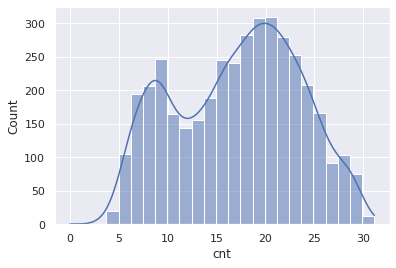

In [62]:
sns.histplot(x='cnt', data=season_1, kde = True)
plt.show()

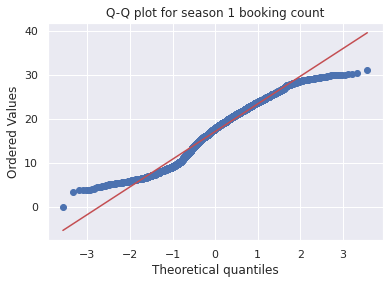

In [63]:
stats.probplot(season_1['cnt'], plot= plt, dist="norm")
plt.title('Q-Q plot for season 1 booking count')
plt.show()

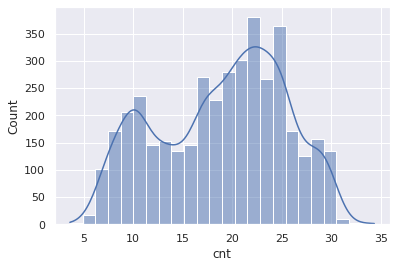

In [64]:
sns.histplot(x='cnt', data=season_2, kde = True)
plt.show()

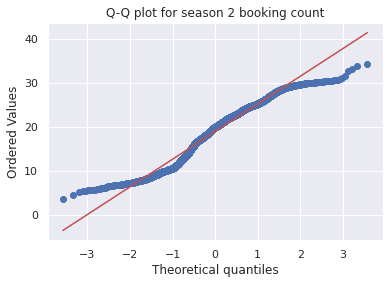

In [65]:
stats.probplot(season_2['cnt'], plot= plt, dist="norm")
plt.title('Q-Q plot for season 2 booking count')
plt.show()

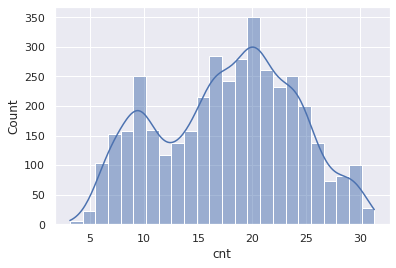

In [66]:
sns.histplot(x='cnt', data=season_3, kde = True)
plt.show()

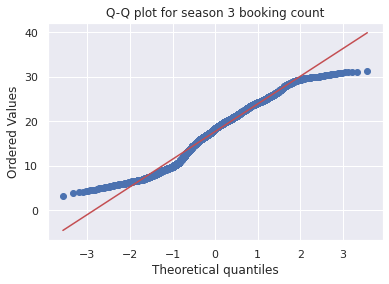

In [67]:
stats.probplot(season_3['cnt'], plot= plt, dist="norm")
plt.title('Q-Q plot for season 3 booking count')
plt.show()

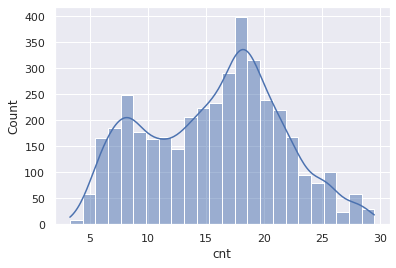

In [68]:
sns.histplot(x='cnt', data=season_4, kde = True)
plt.show()

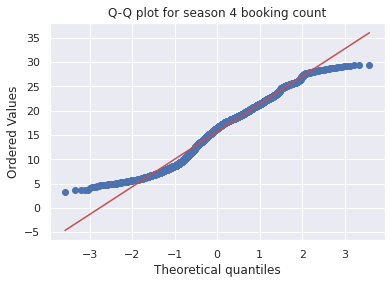

In [69]:
stats.probplot(season_4['cnt'], plot= plt, dist="norm")
plt.title('Q-Q plot for season 4 booking count')
plt.show()

****From the above graphs we can say the values are near to normal for all seasons.****

# Performing Anova 
## Season
****Null hypothesis, H0****        : No. of cycles rented is similar across various season.

****Alternate hypothesis, Ha****   : No. of cycles rented is different across various season.



In [70]:
p_value = stats.f_oneway(season_1['cnt'],season_2['cnt'],season_3['cnt'],season_4['cnt'])[1]
print("P-Value : ",p_value)

P-Value :  1.541646637095961e-119


In [71]:
htResult(p_value)

Reject NULL HYPOTHESIS


## Answer -
****We reject Null Hypothesis, which means No. of cycles rented is different across various seasons.****

# Recommendations - 
- Months like Dec, Jan and Feb sees less amount of booking to increase it we can provide a discount on the booking to attract more customres.
- More users are booking the bike when humidity is less so we can provide offer to add a refreshement during humid weather.
- Working days sees more booking so we can provide an offer during weekends or holidays to bring in more bookings.